In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
# Define directories and hyperparameters
train_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/test'
img_size = (224, 224)
batch_size = 16
epochs = 5
patience = 5

In [6]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12750 images belonging to 17 classes.
Found 7809 images belonging to 17 classes.
Found 33 images belonging to 1 classes.


In [8]:
# Build the model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [9]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [10]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
# Define callbacks
checkpoint = ModelCheckpoint('plant_disease_detection_densenet.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/5



KeyboardInterrupt: 

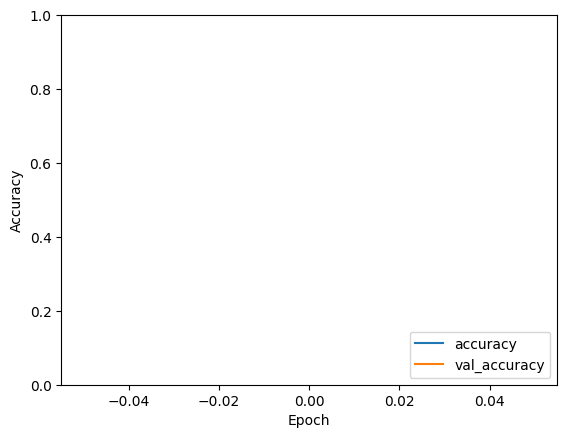

In [14]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [15]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('/nTest accuracy:', test_acc)

3/3 - 1s - loss: 48.1650 - accuracy: 0.0000e+00 - 1s/epoch - 405ms/step

Test accuracy: 0.0


In [3]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

class_indices

NameError: name 'train_generator' is not defined

In [18]:
# Function to predict class of an image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def predict_image(image_path):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_indices[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    return predicted_class, confidence


In [19]:
# Example usage: Predict an image
image_path = 'E:/S8 LAB/New Plant Dataset/New Plant Dataset/train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/3980904f-273e-4191-911b-0ebfc12cf02c___RS_GLSp 4448 copy_270deg.jpg'  # Replace with your image path
predicted_class, confidence = predict_image(image_path)
print(f'Predicted class: {predicted_class}, Confidence: {confidence}')

1/1 [==============================] - 2s 2s/step
Predicted class: Tomato___Late_blight, Confidence: 0.059548716992139816


In [2]:

with open('class_indices_densenet.json', 'w') as f:
    json.dump(class_indices, f)

NameError: name 'class_indices' is not defined